In [1]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab
pylab.rcParams['figure.figsize'] = (10, 10)

In [2]:
from PIL import Image
import cv2

## Read image

In [3]:
img = Image.open('test.png')

In [4]:
print img.mode, img.size, img.format
aimg = np.asarray(img)
print aimg.shape # 4-channel RGBA image

RGBA (2454, 3600) PNG
(3600, 2454, 4)


In [5]:
img = img.convert('L') # convert to grayscale
aimg = np.asarray(img)

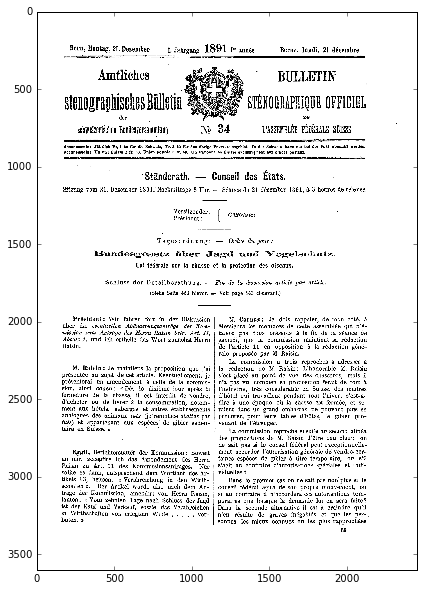

In [6]:
plt.imshow(np.asarray(img), cmap='gray')

In [7]:
W, H = img.size
print W, H

2454 3600


In [8]:
img = cv2.imread('test.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [9]:
gray.shape

(3600, 2454)

## Try to find vertical seperating line 

In [10]:
img = cv2.imread('test.png')
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # convert to grayscale
gray_img = cv2.GaussianBlur(gray,(3,3),0) # denoise image

canny = cv2.Canny(gray_img, 50, 150, apertureSize=5) 
cv2.imwrite('canny.jpg', canny)

# canny image has empty areas inside central line --> maybe directly thresholding shoud be better ? 
binary = cv2.threshold(gray_img, 127,255, cv2.THRESH_BINARY_INV)[-1] 
cv2.imwrite('binary.jpg', binary)
# imshow(binary)

True

### Using HoughLines: doestn't work at all... strange

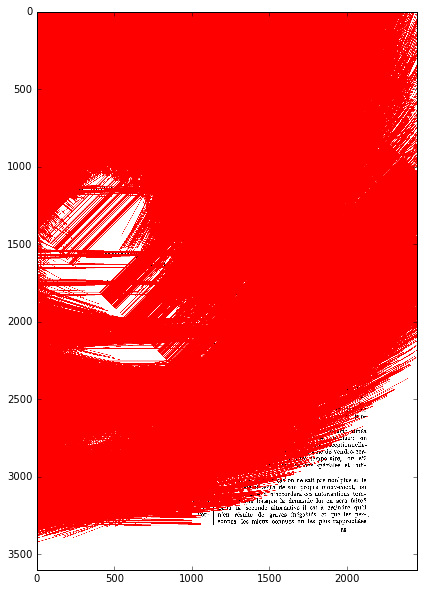

In [12]:
lines = cv2.HoughLines(canny,1,np.pi/180,200).reshape((-1,2))
# print lines.shape
_img = img.copy()

for rho,theta in lines:
#     if np.abs(theta)>np.pi/180*5: continue
#     print rho, theta
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(_img,(x1,y1),(x2,y2),(255,0,0),2)

cv2.imwrite('out.jpg',_img)
plt.imshow(_img)

### Using Proba-version of HoughLines

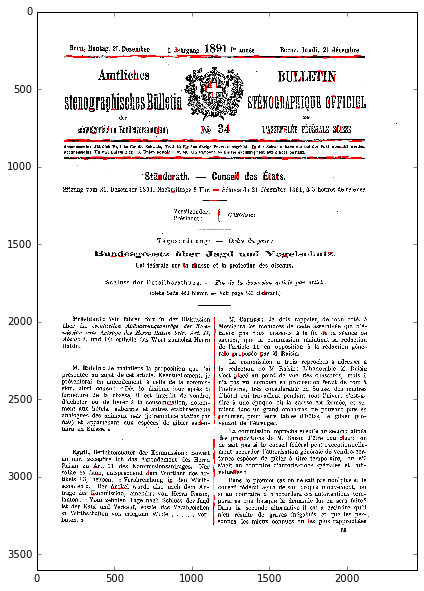

In [13]:
minLineLength = 100
maxLineGap = 20
lines = cv2.HoughLinesP(canny,1,np.pi/2,100,minLineLength,maxLineGap)

_img = img.copy()
for x1,y1,x2,y2 in lines.reshape(-1,4):
    cv2.line(_img,(x1,y1),(x2,y2),(255,0,0),5)

cv2.imwrite('out2.jpg',_img)
plt.imshow(_img)

True

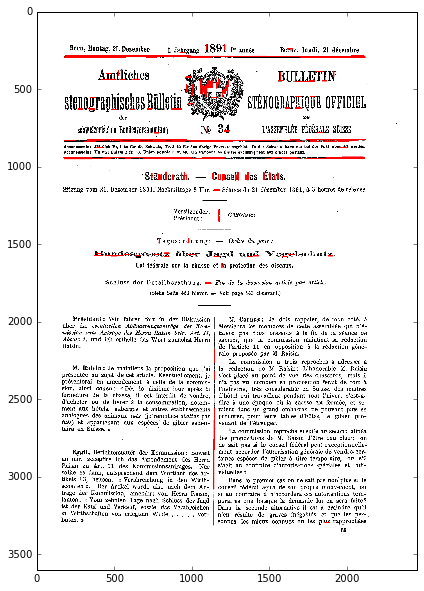

In [15]:
minLineLength = 100
maxLineGap = 30
lines = cv2.HoughLinesP(binary,1,np.pi/2,100,minLineLength,maxLineGap).reshape(-1,4)

_img = img.copy()
for x1,y1,x2,y2 in lines:
    cv2.line(_img,(x1,y1),(x2,y2),(255,0,0),5)

plt.imshow(_img) 
cv2.imwrite('out2_b.jpg',_img)

**TODO: write my own V/H line detector, which should just be a 1d convolution of a all-1 kernel...**

Then for the seperating line we just take the average of the y values of detected lines

In [16]:
avg = []
for x1,y1,x2,y2 in lines:
    if x1==x2:
        avg.append(x1)
V_split = int(np.mean(avg))
print V_split

1139


## Corp the image into left and right part

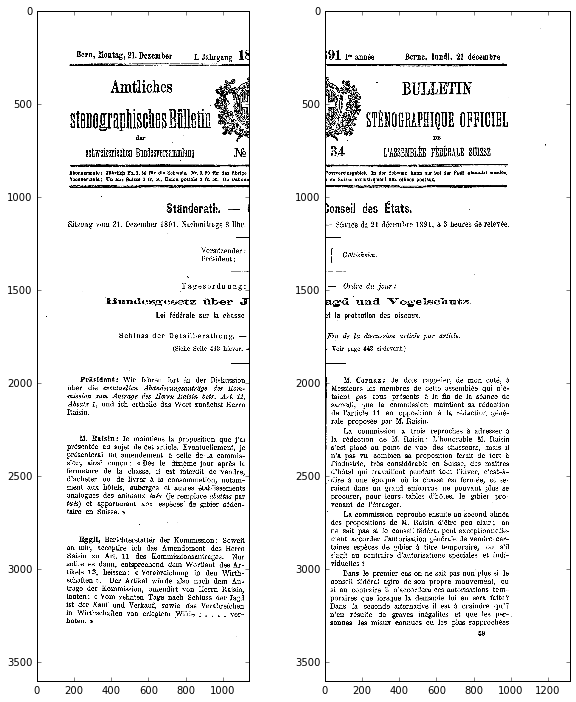

In [17]:
left_img = gray[:,0:V_split+2]
right_img = gray[:,V_split-2:]

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,12))
ax1.imshow(left_img, cmap='gray')
ax2.imshow(right_img, cmap='gray')

## OCR using pyocr

In [18]:
import pyocr
import pyocr.builders
tool = pyocr.get_available_tools()[0]

In [19]:
left_txt = tool.image_to_string(
    Image.fromarray(left_img), 
    lang='deu',
    builder=pyocr.builders.TextBuilder() )
print left_txt

print '=========='

right_txt = tool.image_to_string(
    Image.fromarray(right_img), 
    lang='fra',
    builder=pyocr.builders.TextBuilder() )
print right_txt

Bern, iiontag, 21. Dezember 1, Jahrgang 18
Amtliches _ ’
stanugraplissiasßillalln
schweizeris'chen Bundesversammlung N.»
 
 
 
Abonnemente: JBhrlic_h Fr. 1. 50 für die Schweiz, Fr. 3. 50 für das übrige ]
Abonnemanis: Un an: Suisse [fr. 50, Union postale S fr. 50. On s’abonm
 
'Ständerath. — (
Sitzung vom 21. Dezember 1891.1 Nachmittags 3 Uhr. -
Vorsitzender :
Président :
\
Tagesordnung:
Bundesgesetz über J:
Lei ie’dérale sur la chasse |
Schluss der Detailberathung. ——
(Siehe Seite 443 hievor. -
Präsident: Wir fahren fort in der Diskussion
über die eventuellen Abänderungsanträge der Kom-
mission zum Antrage des Herrn Raz'sz'n betr. Art. 11,
Absatz 1, und ich ertheile das Wort zunächst Herrn
Raisin.
M. Raisin: Je maintiens la proposition que j’ai
présentée au sujet de cet article. Eventuellement, je
pre'senterai un amendement ä celle de la commis-
sion, ainsi coneu: «Des le dixi_éme jour aprés la
ferrneture de la chasse, il est interdit «ie *vendre,
d’acheter ou de livrer' ä la consommat

## Explore what pyocr gives

In [20]:
boxes = tool.image_to_string(
    Image.open('test.png'), builder=pyocr.builders.LineBoxBuilder() )

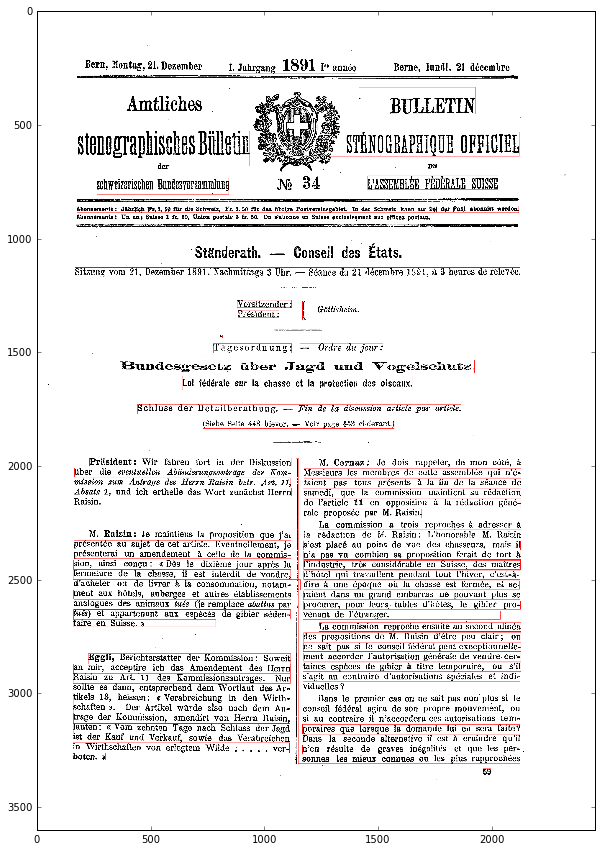

In [21]:
_img = img.copy()
for linebox in boxes:
#     print linebox.content
    p1, p2 = linebox.position
    cv2.rectangle(_img,p1, p2, (255,0,0) )

cv2.imwrite('linebox.jpg', _img)
plt.figure(figsize=(10,16))
plt.imshow(_img)

In [22]:
txt = tool.image_to_string(
    Image.open('test.png'), 
    lang='deu+fra', # seems like the default params are already OK
    builder=pyocr.builders.TextBuilder() )

In [23]:
print txt

Bern, iiontag, 21. Dezember Berne, lundi, 21 décembre
' BULLETIN
‘ STËNÜGBÀPHÏQUE OFFICIEL
L’ASSEMBLÉE FEDERALE SUISSE
I. Jahrgang 1891 I" année
Amtliches _ ’
Staiigrailistiastilliti
StiweizsriSSien Bnniesversammlunu
    
Je 84
Abonnemente: Jährlich Fr. 1. 50 für die Schweiz, Fr. 3. 50 für das übrige Pontvereinsgebiet. In der Schweiz kann nur bal de! Fos! about:: worden.
Abonnements: Un en: Suisse [fr. 50, Union postale 8 fr. 50. On s’abonne en Suisse exclusivement aux ofﬁces postaux.
 
'Ständerath. — Conseil des États.
Sitzung vom 21. Dezember 18914 Nachmittags 3 Uhr. -— Séance du 21 décembre 1891, a 3 heures de relevée.
Vorsitzender :
Président :
\
Tagesordnung:
{ Göttislzez'm.
—- Ordre du jour:
Bundesgesetz über Jagd ‚und Vogelseiruüz.
Loi fédérale sur la chasse et la protection des oiseaux.
Schluss der Detailberathung. —— Fin de la discussion article par article.
(Siehe Seite 443 hievor. .- Voir page 443 ci-devant.)
Präsident: Wir fahren fort in der Diskussion
über die eventuellen 

## TODO: name extraction